        Prototyping notebook for predicting stock volaitility, prices, etc using extra data from web trends, news, etc. 

        Since this notebook takes a tremendous ammount of data to run, it is not included in the repo. All the necessary steps to aquiring the data are included in the notebook however, although the twitter scraper might become broken as twitter changes their API to block scraping.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('io.parquet.engine', 'pyarrow')
import numpy as np
import os
import gc, os
from getpass import getpass
from utils import *
from models import *
import gc
import shutil
import zipfile
import torch
import arrow
import matplotlib.pyplot as plt
import torch



# currently hardcoded to use GPU in order to identify when cuda is installed incorrectly. The models will not be practical to train on CPU
cuda = torch.device("cuda") 
cpu = torch.device("cpu")
# if you don't need the API downloads, you can set this to False
use_api = False

38
seed=42
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.default_rng(seed=seed) 
MODEL = 'cardiffnlp/twitter-xlm-roberta-base-sentiment' #cardiffnlp/twitter-xlm-roberta-base-sentiment  cardiffnlp/twitter-roberta-base-emotion
print('Available GPU memory:', available_mem(), 'GB')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Available GPU memory: 20.177 GB


In [2]:
# 1: Enter password to save/load API keys. This will be used to create/subsequently unlock the encrypted API keys.
# 2: if it is the first time running this, this will ask you to enter your username + a single space + your Kaggle API key. (don't use quotes)
# 3: any other api keys in future will follow the same format

# # may take awhile to load the first time, depending on your internet speeds. 
# After this first run, you will only need to enter the password to load the api keys 
# NOTE: Don't delete or move salt.secret as all tokens will become undecryptable. 
# If you made a mistake or need to retry, you may 1) delete salt.secret to reset everything. 2) delete the specific .secret key to re-enter only that info.
if use_api:
    # Ask for input of password to save API keys
    password = getpass("Enter password to save/load API keys: ");
    if len(password) > 0:
        kaggle_api_key = fernet_key_encryption(password, 'Kaggle');
        #td_ameritrade_api_key = fernet_key_encryption(password, 'TD_Ameritrade')
        #data_nasdaq_key = fernet_key_encryption(password, 'Nasdaq');
        del password;
        gc.collect();
        get_datasets(kaggle_api_key);
    elif len(glob('data/*')) < 4:
        cont = input(f"Password is empty. Press n to cancel or any other key to continue: ")
        if cont == 'n':
            assert False, "Exiting program. Please enter a password to continue."

In [3]:
# gathers a dataframe of useful terms and info related to every stock in data\Stock_List.parquet. This may take up to 40 minutes to run the first time (the web scraping is slow due to requests being throttled). Stores results in company_list.pkl
search_terms = aquire_stock_search_terms('data/Stock/')

In [4]:
update_stock_data(ticker='KR', save = True)
update_stock_data(ticker='AAPL', save = True)
update_stock_data(ticker='TSLA', save = True)

TSLA is up to date.: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


In [5]:
# These are used to scrape tweets from twitter. However, it has recently stopped working due to aggressive rate limiting/anti-bot measures.

if False:
    search = search_terms.data[search_terms.data['ticker'] == 'KR'].values.tolist()[0][0:4]
    search = [x.lower() for x in search if x != None and x != '']
    search[0] = '#' + search[0]
    df_if_error = scrape_tweets(since='2018-01-01', until='2023-04-19', max_tweets=20, update_twitter_data=True, co_list=search)

    search = search_terms.data[search_terms.data['ticker'] == 'AAPL'].values.tolist()[0][0:4]
    search = [x.lower() for x in search if x != None and x != '']
    search[0] = '#' + search[0]
    df_if_error = scrape_tweets(since='2018-01-01', until='2023-04-19', max_tweets=20, update_twitter_data=True, co_list=search)


    # search = search_terms.data[search_terms.data['ticker'] == 'TSLA'].values.tolist()[0][0:4]
    # search = [x.lower() for x in search if x != None and x != '']
    # search[0] = '#' + search[0]
    # df_if_error = scrape_tweets(since='2018-01-01', until='2023-04-19', max_tweets=20, update_twitter_data=True, co_list=search)
    

# how to recover the data if the crawler crashes (example for apple inc.)
#tweets_df = pd.DataFrame(df_if_error, columns=['date', 'text', 'username', 'searchterm'])
#tweets_df = tweets_df.drop_duplicates(inplace=False, subset=['date', 'text', 'username', 'searchterm']).reset_index(drop=True, inplace=False).dropna(inplace=False)
#save_file(tweets_df, r'data\Twitter\twitter_data___#APPL---apple inc.---timothy cook---consumer electronics.parquet')

In [6]:
emotion_classifier = emotion_classifier_load(MODEL)
text_df = classify_twitter_text(save_path='data/Text/text_emotion_29.parquet', model=emotion_classifier, load_path='data/Text/text_emotion_29.parquet')
text_df = text_df.drop(columns=['stock','text'], inplace=False).dropna(inplace=False)
# len date row chars > 7
text_df = text_df[text_df['date'].str.len() > 7]
text_df


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([120, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([120]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,date,emotion
2480308,1969-12-31 00:00:00,"[2.7829293813952536e-34, 0.0, 0.0, 0.0, 1.5069..."
869809,2009-02-14 14:02:00-05:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8025969286496..."
1380086,2009-04-27 14:39:00-04:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.21726807..."
512898,2009-04-27 14:39:00-04:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.21726807..."
1806,2009-04-29 08:48:00-04:00,"[1.453917221660214e-40, 0.0, 2.662467082217152..."
...,...,...
1029407,2020-06-11 16:49:00-04:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.18590352..."
1347700,2020-06-11 16:51:00-04:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1259311,2020-06-11 17:01:00-04:00,"[0.0, 0.0, 0.0, 3.737679175276651e-25, 0.0, 0...."
970991,2020-06-11 17:11:00-04:00,"[0.0, 0.0, 0.0, 0.0, 3.3818431745755833e-32, 0..."


In [7]:
index = glob('data/Twitter/twitter_emotion___#*.parquet')
index = {x.split("#")[1].split("---")[0]: x for x in index}

kr_text =   load_file(index['kr'].replace('emotion', 'data'))
aapl_text = load_file(index['aapl'].replace('emotion', 'data'))

kr_df   = classify_twitter_text(save_path=index['kr'], model=emotion_classifier, load_path=index['kr'].replace('emotion', 'data'))
aapl_df = classify_twitter_text(save_path=index['aapl'], model=emotion_classifier, load_path=index['aapl'].replace('emotion', 'data'))
aapl_df

,date,text,emotion
0,2018-01-01,Sell In May And Go Away? https://t.co/oJMX95LA...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0516701841139..."
20,2018-01-01,DAL Looks Done\nhttps://t.co/1EGcnMdurR ...,"[2.7646217402664316e-41, 0.0, 0.0, 9.339321316..."
19,2018-01-01,WMT Clinging To Its Upper Channel Line\nhttps:...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.27672934..."
18,2018-01-01,ORCL Continues the Slow Controlled Drift Lower...,"[0.0, 0.0, 0.0, 0.0, 7.682882659998132e-28, 0...."
17,2018-01-01,CSCO Over Does It\nhttps://t.co/1EGcnMdurR ...,"[4.4474090492067915e-36, 0.0, 0.0, 8.190071043..."
...,...,...,...
11034,2019-08-13,4 hour charts for all 78 instruments are avail...,"[0.0, 0.0, 0.0, 0.0, 6.044013273999513e-38, 0...."
11033,2019-08-13,1 hour charts for the Group 3 instruments are ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.54820393..."
11051,2019-08-13,Always good coming back from vacation for a ma...,"[0.0, 0.0, 0.0, 0.0, 1.9602515582448047e-30, 1..."
11041,2019-08-13,AAPL vs. USDJPY intraday... have been watching...,"[0.0, 0.0, 0.0, 1.1627316795169917e-30, 6.9916..."


In [8]:
# These calls 1) load the stock data, 2) intersect the stock data with the text data, and 3) calculate the daily stats for the stock and text data. Daily stats converts the 20 or so tweets per day into a single row of data with the mean, std, and other stats for the day.

# kr stock
stock_kr = load_file('data/Stock/KR.parquet')
kr_df['date'] = kr_df['date'].apply(lambda x: arrow.get(str(x)[:10]).format('YYYY-MM-DD') if len(str(x)) > 7 else None).dropna()
kr_stats = daily_stats(kr_df)

stock_kr = load_file('data/Stock/KR.parquet')
stock_kr, text_df_kr = intersect_df(stock_kr, text_df)
text_stats_kr = daily_stats(text_df_kr)
text_df_kr = daily_stats(text_df_kr)



# aapl stock
stock_aapl = load_file('data/Stock/AAPL.parquet')
aapl_df['date'] = aapl_df['date'].apply(lambda x: arrow.get(str(x)[:10]).format('YYYY-MM-DD') if len(str(x)) > 7 else None).dropna()
aapl_stats = daily_stats(aapl_df)

stock_aapl = load_file('data/Stock/AAPL.parquet')
stock_aapl, text_df_appl = intersect_df(stock_aapl, text_df)
text_stats_appl = daily_stats(text_df_appl)
text_df_appl = daily_stats(text_df_appl)

twitter to emotion dataframe

feature list: 

              emotions        [std, mean, count],                                 --> no need to normalize
              
              stock           [open, high, low, close, volume],                   --> normalize percent change

              portfolio       [current money, stocks owned, stocks owned value],  --> keep track of portfolio

              date            [day of week, holiday, day of month, month]         --> engineer

              economic data   [NA]                                                --> normalize 

output: 

  volatility:

  best action

  predicted price


In [13]:
# Process kroger data. 1) Merge global, stock, and company specific data into a timeseries, with zeros for missing data. 2) Split into train and test sets. 3) Scale the data. 4) Reshape the data into 3D for Resnet, 5) ensure data ordering and labels are correct

merged_df_kr = merge_data_timeline(kr_stats, stock_kr, text_stats_kr)
y_cols = ['open', 'high', 'low', 'close', 'volume']
x_cols = merged_df_kr.columns #  if x not in y_cols and x != 'date'... not removed because it is current day's data and we want to predict next day's data
X = merged_df_kr[x_cols]
Y = merged_df_kr[y_cols]
#delete the first row to allign the data
Y = Y.drop(Y.index[0]) # y is now the next day's data... e.g. we want to predict tomorrow's stock price
X = X.drop(X.index[-1]) 

# complete timeseries
Y = Y.values
X = X.values

# split into train and test sets by slicing
train_size = int(len(X) * 0.90)
test_size = len(X) - train_size

X_train, Y_train_kr = X[0:train_size,:], Y[0:train_size,:]
X_test, Y_test_kr = X[train_size:len(X),:], Y[train_size:len(Y),:]

dates_train = X_train[:,0]
dates_test = X_test[:,0]
X_train = X_train[:,1:].astype('float32')
X_test = X_test[:,1:].astype('float32')

# split dim 1 into 2
split_into = 2
X_train_kr = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_kr = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
#################################################################################################################################
# process apple data
merged_df_aapl = merge_data_timeline(aapl_stats, stock_aapl, text_stats_appl)
y_cols = ['open', 'high', 'low', 'close', 'volume']
x_cols = merged_df_kr.columns #  if x not in y_cols and x != 'date'... not removed because it is current day's data and we want to predict next day's data
X = merged_df_aapl[x_cols]
Y = merged_df_aapl[y_cols]
#delete the first row to allign the data
Y = Y.drop(Y.index[0]) # y is now the next day's data... e.g. we want to predict tomorrow's stock price
X = X.drop(X.index[-1]) 

# complete timeseries
Y = Y.values
X = X.values

# split into train and test sets by slicing
train_size = int(len(X) * 0.90)
test_size = len(X) - train_size

X_train, Y_train_aapl = X[0:train_size,:], Y[0:train_size,:]
X_test, Y_test_aapl = X[train_size:len(X),:], Y[train_size:len(Y),:]

dates_train = X_train[:,0]
dates_test = X_test[:,0]
X_train = X_train[:,1:].astype('float32')
X_test = X_test[:,1:].astype('float32')

# split dim 1 into 2
split_into = 2
X_train_aapl = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_aapl = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [37]:
class PortfolioTracker():
    def __init__(self, cash=1000, ticker='KR'):
        self.portfolio_history = {'cash': [], 'stocks': [], 'total': [], 'action': []}
        self.cash = cash
        self.price = torch.as_tensor(0, dtype=torch.float32)
        self.stocks = torch.as_tensor(0, dtype=torch.float32)
        self.stock_ticker_symbol = ticker
        self.i_train = 0
        self.i_test = 0
        self.start_cash = torch.as_tensor(10000, dtype=torch.float32)
        self.get_stock_history(ticker)

    def action(self, amount, train=True, track=False):
        """actions are either 0, 1, or -1"""
       
        amount = amount.squeeze(0).item()
        if train: 
            price = torch.as_tensor(self.train['close'][self.i_train], dtype=torch.float32)
            self.i_train += 1
            if self.i_train >= len(self.train): self.i_train = 0
        else: 
            price = torch.as_tensor(self.test['close'][self.i_test], dtype=torch.float32)
            self.i_test += 1
            if self.i_test >= len(self.test): self.i_test = 0

        self.price = price
        price.requires_grad = True
        old_value = self.get_value(price)

        with torch.no_grad():
            if amount > 0.33:
                if self.cash >= price:
                    self.cash = torch.subtract(self.cash, price)
                    self.stocks = torch.add(self.stocks, 1.0)
                else:
                    pass
            elif amount < -0.33:
                if self.stocks >= 1.0:
                    self.cash = torch.add(self.cash, price)
                    self.stocks = torch.subtract(self.stocks, 1.0)
                else:
                    pass
            else:
                pass

        new_value = self.get_value(price)

        # maximize profit (reward)
        change =  old_value - new_value # change in portfolio value from last action
        diff_from_start = self.start_cash - new_value # overall model profit
        
        if track:
            self.portfolio_history['cash'].append(self.cash.detach().numpy())
            self.portfolio_history['stocks'].append(self.stocks.detach().numpy())
            self.portfolio_history['total'].append(self.cash.detach().numpy() + self.stocks.cpu().detach().numpy() * price.detach().numpy())
            if amount > 0.33:
                if self.cash >= price:
                    self.portfolio_history['action'].append('buy')
                else:
                    self.portfolio_history['action'].append('hold')
            elif amount < -0.33:
                if self.stocks >= 1.0:
                    self.portfolio_history['action'].append('sell')
                else:
                    self.portfolio_history['action'].append('hold')
            else:
                self.portfolio_history['action'].append('hold')
        
        loss1 = torch.as_tensor(change, dtype=torch.float32).to('cuda')
        loss2 = torch.as_tensor(diff_from_start, dtype=torch.float32).to('cuda')
        #loss = torch.max(loss1+loss2 + 100, torch.as_tensor(0, dtype=torch.float32).to('cuda'))
        loss = 1 / (1 + torch.exp(-loss1)) + 1 / (1 + torch.exp(-loss2))
        return loss
        
    def get_value(self, price):
        return torch.add(self.cash,  torch.multiply(self.stocks, price))

    def get_portfolio_tensor(self):
        p1 = torch.as_tensor(self.cash, dtype=torch.float32).cpu().reshape(1,)
        p2 = torch.as_tensor(self.stocks, dtype=torch.float32).cpu().reshape(1,)
        p3 = torch.as_tensor(self.price, dtype=torch.float32).cpu().reshape(1,)
        portfolio_data = torch.concat((p1, p2, p3), 0)
        p = portfolio_data.to('cuda')
        return p

    def get_stock_history(self, ticker):
        self.train = load_file(f'data/Stock/{ticker}.parquet')
        self.test = load_file(f'data/Stock/{ticker}.parquet')

class StockModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(StockModel, self).__init__()
        self.num_classes = num_classes
        self.resnet = models.resnet18(pretrained=False)
        self.new_input_size = input_size
        # update resnet input size
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.conv1.weight = nn.Parameter(self.resnet.conv1.weight.sum(dim=1, keepdim=True))
        self.resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.resnet.fc = nn.LazyLinear(self.num_classes)
        # add head for RL agent
        self.rl_head = nn.LazyLinear(1)
        self.dense_portfolio = nn.LazyLinear(5)
        self.dense_resnet = nn.LazyLinear(5)
        self.dense = nn.LazyLinear(5)

    def forward(self, x, portfolio):
        """forward pass. Here we take the resnet model and add a head for the RL agent to learn from. This forward pass will then output the action taken and the pred_price for price.
        
        """
        # regular resnet forward pass
        pred_price = self.resnet(x)
        
        # rl head forward pass
        dense_portfolio = self.dense_portfolio(portfolio)
        out1 = torch.squeeze(pred_price, 0)
        dense_portfolio = torch.squeeze(dense_portfolio, 0)
        dense_resnet = self.dense_resnet(out1)
        dense = torch.cat((dense_portfolio, dense_resnet))
        outcat2 = torch.concat((dense, out1))
        action = self.rl_head(outcat2)

        # 
        pred_price = torch.functional.F.softmax(pred_price, dim=1)
        return pred_price, action.to('cuda')

In [38]:
window_Size = 32
X_train_win_kr = sliding_window_view_generator(X_train_kr, window_Size)
X_test_win_kr = sliding_window_view_generator(X_test_kr, window_Size)
Y_train_win_kr = sliding_window_view_generator(Y_train_kr, 1)
Y_test_win_kr = sliding_window_view_generator(Y_test_kr, 1)

X_train_win_aapl = sliding_window_view_generator(X_train_aapl, window_Size)
X_test_win_aapl = sliding_window_view_generator(X_test_aapl, window_Size)
Y_train_win_aapl = sliding_window_view_generator(Y_train_aapl, 1)
Y_test_win_aapl = sliding_window_view_generator(Y_test_aapl, 1)

criterion = nn.MSELoss()
criterion = criterion.to(device)
model = StockModel((1, window_Size, 216), Y_test_win_kr.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# vars
best_loss = np.inf
best_epoch = 0
best_model_perams = None
hist = {'train_loss_kr': [], 'test_loss_kr': [], 'train_loss_aapl': [], 'test_loss_aapl': []}
num_epochs = 2
early_stopping = True


# Train and test the model on both the KR and AAPL data
try:
    with tqdm(total=num_epochs * (len(X_train_win_kr.x) + len(X_test_win_kr.x) + len(X_train_win_aapl.x) + len(X_test_win_aapl.x))) as pbar:

        for epoch in range(num_epochs):
            X_train_win_kr.current_index = 0
            Y_train_win_kr.current_index = 0
            model.train()
            portfolio_tracker = PortfolioTracker(torch.as_tensor(10000, dtype=torch.float32).unsqueeze(0), ticker = 'KR')
            # Train the model on the KR  data
            for i in range(len(X_train_win_kr.x)):
                # Forward pass
                #model.train()
                x = next(X_train_win_kr.next())
                y = next(Y_train_win_kr.next())
                predictions, actions  = model.forward(x, portfolio_tracker.get_portfolio_tensor())
                loss_action = portfolio_tracker.action(actions, train=True, track=False)
                loss_predic = criterion(predictions, y)
                loss = loss_action + loss_predic
                loss = loss

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                hist['train_loss_kr'].append(loss.item())
                avg_loss = np.mean(hist['train_loss_kr']) if len(hist['train_loss_kr']) > 0 else np.mean(hist['train_loss_kr'])
                if i % 100 == 0:pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.16f}')
                pbar.update(1)

            portfolio_tracker = PortfolioTracker(torch.as_tensor(10000, dtype=torch.float32).unsqueeze(0), ticker = 'AAPL')
            X_train_win_aapl.current_index = 0
            Y_train_win_aapl.current_index = 0
            model.train()
            # Train the model on aapl data
            for i in range(len(X_train_win_kr.x)):
                # Forward pass
                #model.train()
                x = next(X_train_win_kr.next())
                y = next(Y_train_win_kr.next())
                predictions, actions  = model.forward(x, portfolio_tracker.get_portfolio_tensor())
                #sleep(1000)
                loss_action = portfolio_tracker.action(actions, train=True, track=False)
                loss_predic = criterion(predictions, y)
                loss = loss_action + loss_predic
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
                hist['train_loss_aapl'].append(loss.item())
                avg_loss = np.mean(hist['train_loss_aapl']) if len(hist['train_loss_aapl']) > 0 else np.mean(hist['train_loss_aapl'])
                if i % 100 == 0:pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.16f}')
                pbar.update(1)

            model.eval()
            portfolio_tracker = PortfolioTracker(torch.as_tensor(10000, dtype=torch.float32).unsqueeze(0), ticker = 'KR')
            Y_test_win_kr.current_index = 0
            X_test_win_kr.current_index = 0
            test_eval_hist = []
            with torch.no_grad():
                for i in range(len(X_test_win_kr.x)):
                    x = next(X_test_win_kr.next())
                    y = next(Y_test_win_kr.next())
                    predictions, actions = model.forward(x, portfolio_tracker.get_portfolio_tensor())
                    #sleep(1000)
                    loss_action = portfolio_tracker.action(actions, train=False, track=False)
                    loss_predic = criterion(predictions, y)
                    loss = loss_action + loss_predic
                    hist['test_loss_kr'].append(loss.item())
                    test_eval_hist.append(loss.item())
                    avg_loss = np.mean(hist['test_loss_kr']) if len(hist['test_loss_kr']) > 0 else np.mean(hist['test_loss_kr'])
                    if i % 100 == 0:pbar.set_description(f'Testing Kroger, Loss: {avg_loss:.16f}')
                    pbar.update(1)

            model.eval()
            portfolio_tracker = PortfolioTracker(torch.as_tensor(10000, dtype=torch.float32).unsqueeze(0), ticker = 'AAPL')
            Y_test_win_aapl.current_index = 0
            X_test_win_aapl.current_index = 0
            
            with torch.no_grad():
                for i in range(len(X_test_win_aapl.x)):
                    x = next(X_test_win_aapl.next())
                    y = next(Y_test_win_aapl.next())
                    predictions, actions = model.forward(x, portfolio_tracker.get_portfolio_tensor())
                    #sleep(1000)
                    loss_action = portfolio_tracker.action(actions, train=False, track=True)
                    loss_predic = criterion(predictions, y)
                    loss = loss_action + loss_predic
                    hist['test_loss_aapl'].append(loss.item())
                    test_eval_hist.append(loss.item())
                    avg_loss = np.mean(hist['test_loss_aapl']) if len(hist['test_loss_aapl']) > 0 else np.mean(hist['test_loss_aapl'])
                    if i % 100 == 0:pbar.set_description(f'Testing Apple, Loss: {avg_loss:.16f}')
                    pbar.update(1)

                # if early_stopping:
                #     if np.mean(test_eval_hist) < best_loss:
                #         best_loss = avg_loss
                #         best_epoch = epoch
                #         best_model_perams = model.state_dict()
                #         best_optimizer_perams = optimizer.state_dict()
                #     else:
                #         model = model.load_state_dict(best_model_perams)
                #         optimizer = optimizer.load_state_dict(best_optimizer_perams)
                #         print(f'Early stopping at epoch {epoch}')
                #         break

except KeyboardInterrupt:
    print('Training interrupted by user')
    pass

  0%|          | 0/108582 [00:00<?, ?it/s]

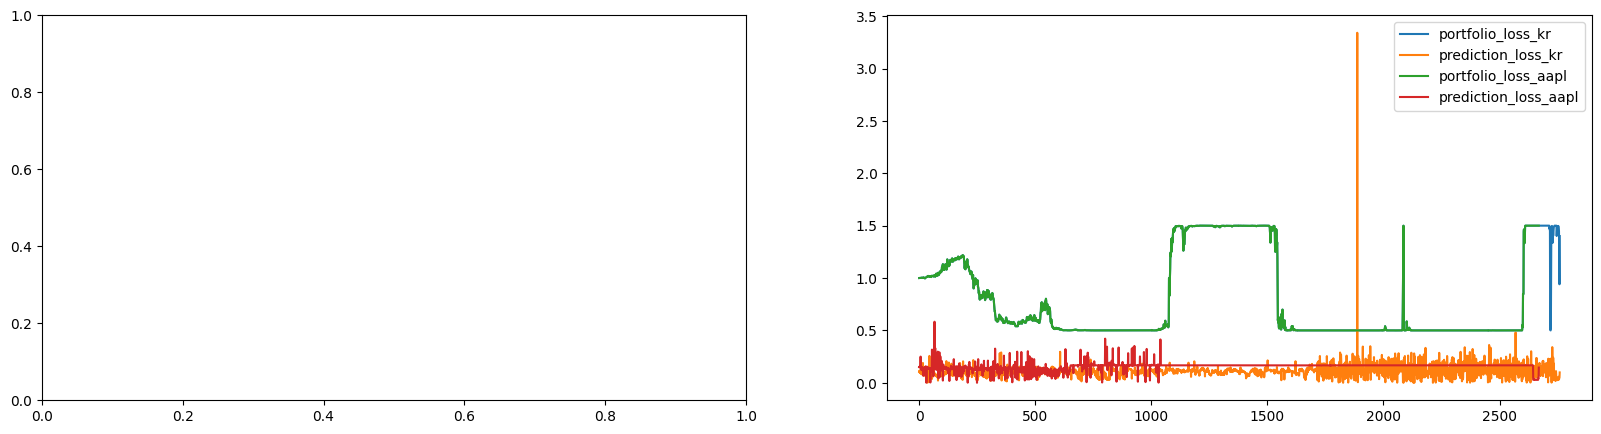

In [46]:
subplots_4 = plt.subplots(1, 2, figsize=(20, 5))

for key, l in hist.items():
    if 'train' in key:
        plt.subplot(1, 2, 1)
        plt.plot(l, label=key)
        plt.legend()
    else:
        plt.subplot(1, 2, 2)
        plt.plot(l, label=key)
        plt.legend()

plt.show()
plt.savefig('results/train_losses.png')

In [41]:
# Test the model
portfolio_tracker = PortfolioTracker(torch.as_tensor(10000, dtype=torch.float32).unsqueeze(0), ticker = 'KR')
hist = {'portfolio_loss_kr':[], 'prediction_loss_kr':[], 'portfolio_loss_aapl':[], 'prediction_loss_aapl':[]}

Y_test_win_kr.current_index = 0
X_test_win_kr.current_index = 0
with torch.no_grad():
    for i in range(len(X_test_win_kr.x)):
        x = next(X_test_win_kr.next())
        y = next(Y_test_win_kr.next())
        predictions, actions = model.forward(x, portfolio_tracker.get_portfolio_tensor())
        loss_action = portfolio_tracker.action(actions, train=False, track=True)
        loss_predic = criterion(predictions, y)
        loss = loss_action# + loss_predic
        hist['portfolio_loss_kr'].append(loss_action.item())
        hist['prediction_loss_kr'].append(loss_predic.item())
        avg_loss = np.mean(hist['portfolio_loss_kr']) if len(hist['portfolio_loss_kr']) > 0 else np.mean(hist['portfolio_loss_kr'])
        if i % 100 == 0:pbar.set_description(f'Testing Kroger, Loss: {avg_loss:.16f}')
        pbar.update(1)

portfolio_tracker = PortfolioTracker(torch.as_tensor(10000, dtype=torch.float32).unsqueeze(0), ticker = 'AAPL')

Y_test_win_aapl.current_index = 0
X_test_win_aapl.current_index = 0
with torch.no_grad():
    for i in range(len(X_test_win_aapl.x)):
        x = next(X_test_win_aapl.next())
        y = next(Y_test_win_aapl.next())
        predictions, actions = model.forward(x, portfolio_tracker.get_portfolio_tensor())
        loss_action = portfolio_tracker.action(actions, train=False, track=True)
        loss_predic = criterion(predictions, y)
        loss = loss_action# + loss_predic
        hist['portfolio_loss_aapl'].append(loss_action.item())
        hist['prediction_loss_aapl'].append(loss_predic.item())
        avg_loss = np.mean(hist['portfolio_loss_aapl']) if len(hist['portfolio_loss_aapl']) > 0 else np.mean(hist['portfolio_loss_aapl'])
        if i % 100 == 0:pbar.set_description(f'Testing Apple, Loss: {avg_loss:.16f}')
        pbar.update(1)


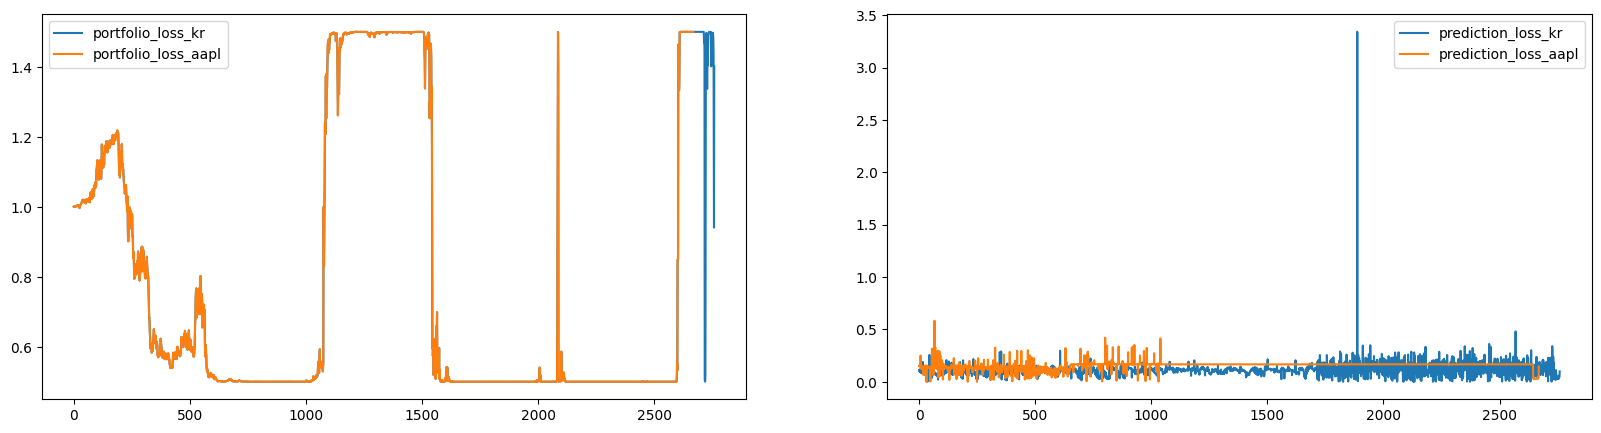

In [45]:
subplots_4 = plt.subplots(1, 2, figsize=(20, 5))

for key, l in hist.items(): 
    if 'portfolio' in key:
        plt.subplot(1, 2, 1)
        plt.plot(l, label=key)
        plt.legend()
    else:
        plt.subplot(1, 2, 2)
        plt.plot(l, label=key)
        plt.legend()
plt.savefig('results/test_losses.png')
plt.show()


In [53]:
for key, l in portfolio_tracker.portfolio_history.items():
    print(f"{key}: {l[-1]}")
#self.portfolio_history = {'cash': [], 'stocks': [], 'total': [], 'action': []}
print(f"Total assets at end AAPL: {portfolio_tracker.portfolio_history['total'][-1] - portfolio_tracker.portfolio_history['total'][0]}")
print(f"Total assets at end KR: {portfolio_tracker.portfolio_history['total'][-1] - portfolio_tracker.portfolio_history['total'][0]}")


cash: [9885.103]
stocks: 2670.0
total: [9980.557]
action: buy
Total assets at end AAPL: [-19.44336]
Total assets at end KR: [-19.44336]
